# Making it faster

## I think since SGHMC, and HMC sampling algorithms depend on the input function U, it is very hard to do general optimizaition, plus I think the most time-consuming part is actually the computation of U and gradient of U. Thus I think it is better to do problem-specific optimization, meaning that we optimize U for different problems. Here I will try to optimize U specifically for Bayesian logistic regression

## Again using the simulated data sets 
## Generate binary classification data with $p(x=1) = \frac{1}{1+e^{25.-0.5x}}$

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import numba
from numba import jit, vectorize, float64, int64

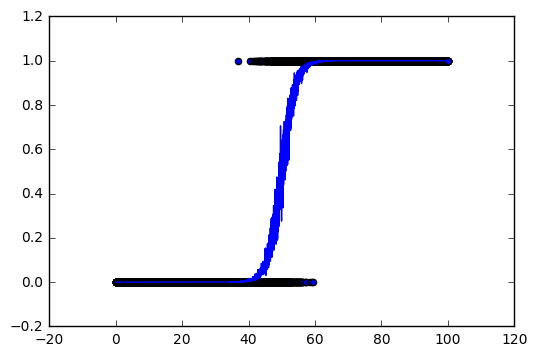

In [3]:
xi = 0.0
xf = 100.0
n = 10000

def logistic(beta,x):
    x = np.c_[np.ones_like(x), x]
    beta_x = (beta*x).sum(axis=1)  + np.random.randn(x.shape[0]) * 0.3
    return 1./(1. + np.exp(-beta_x))

beta = np.array([-25.,0.5])

x = np.linspace(xi,xf,n)

p = logistic(beta, x)

y = np.zeros_like(x)
for i in range(len(x)):
    if np.random.random() < p[i]:
        y[i] = 1.

Data = np.c_[x,y]
plt.scatter(x, y)
plt.plot(x, p)

### data should be grouped in such a way that the last column is the y values, and other columns corresponds to the x's.

Below, the $U(data, beta)$ is the potential energy. For logistic regression (binary, y = \{0,1\}), this is 
$$\sum_{x,y \in Data} log(1+e^{(-1)^y (\beta_0 + \beta_1 x_1 +\cdots)}) $$, the $p(\beta)$ is the prior distribution of $\beta$. THIS MODEL ASSUMES THAT $\beta_0$ IS NOT 0!!!SO IT HAS TO BE MODIFIED OTHERWISE

$gradU\_exact(data, beta)$ is the gradient of the potential energy. 
$$\frac{\partial U(\beta)}{\partial \beta_i} = \sum_{x,y \in Data} \frac{(-1)^y x_i }{1+e^{(-1)^{y+1} (\beta_0 + \beta_1 x_1 +\cdots)}} $$

$gradU\_SG(data, beta)$ uses only minibatch of the total data to compute the summation appearing in the gradient, plus a normal noise.

Here we are just using a uniform prior, i.e. $logp(\beta) = 0$

In [4]:
def U(data, beta):
    dataX = data[:,:-1] 
    dataY = data[:,-1]
    dataX = np.c_[np.ones_like(dataX[:,0]), dataX]
    beta_X = (beta*dataX).sum(axis=1)
    pdata = (np.log(1. + np.exp( ((-1.)**dataY) * beta_X) )).sum() 
    return pdata

def gradU_exact(data, beta):
    dataX = data[:,:-1] 
    dataY = data[:,-1]
    dataX = np.c_[np.ones_like(dataX[:,0]), dataX]
    beta_X = (beta*dataX).sum(axis=1)
    
    der_temp = ((-1.)**dataY)/(1. + (np.exp( ((-1.)**(dataY+1.)) * beta_X )) )
    ddata = (der_temp[:, None] * dataX).sum(axis=0)

    
    return ddata

def gradU(data, minibatch, beta):
    '''using minibatch of the original data to compute the gradient'''
    
    dataX = data[:,:-1] 
    dataY = data[:,-1]
    dataX = np.c_[np.ones_like(dataX[:,0]), dataX]
    beta_X = (beta*dataX).sum(axis=1)
    
    der_temp = ((-1.)**dataY)/(1. + (np.exp( ((-1.)**(dataY+1.)) * beta_X )) )
    ddata = (der_temp[:, None] * dataX)
    ##### using minibatch of the data #####
    ddata = ddata[np.random.choice(ddata.shape[0], int(minibatch * ddata.shape[0]), replace=False),:].sum(axis=0) 
    #################################
    
    
    return (1./minibatch)*ddata

In [6]:
%%file wrap_U.cpp
<%
cfg['compiler_args'] = ['-std=c++11']
cfg['include_dirs'] = ['eigen']
setup_pybind11(cfg)
%>

// use different path or git clone https://github.com/RLovelett/eigen.git

#include <pybind11/pybind11.h>
#include <pybind11/eigen.h>

#include <Eigen/LU>
#include <Eigen/Dense>

#include <vector>
#include <random>

#include "eigenmvn.h"

namespace py = pybind11;


double U_c(Eigen::MatrixXd data, Eigen::VectorXd beta) {
    Eigen::MatrixXd dataX = Eigen::MatrixXd::Ones(data.rows(), data.cols());
    for (int i =0; i< dataX.cols()-1; i++){
          dataX.col(i+1) = data.col(i);      
    }
    
    Eigen::VectorXd dataY;
    dataY = data.col(data.cols()-1);
    
    Eigen::VectorXd beta_X = dataX * beta;
    
    Eigen::VectorXd denom = 1. + beta_X.array().exp();
    denom = -1.*denom.array().log();
    
    Eigen::VectorXd numer = (dataY.array()) * (beta_X.array());
    
    double sum = (numer.sum() + denom.sum());
    
    return -1.*sum;
    
}


Eigen::VectorXd gradU_c(Eigen::MatrixXd data, double minibatch, Eigen::VectorXd beta){
    Eigen::MatrixXd dataX = Eigen::MatrixXd::Ones(data.rows(), data.cols());
    for (int i =0; i< dataX.cols()-1; i++){
          dataX.col(i+1) = data.col(i);      
    }
    
    Eigen::VectorXd dataY;
    dataY = data.col(data.cols()-1);
    
    Eigen::VectorXd beta_X = dataX * beta;
    
    Eigen::VectorXd beta_X_exp = beta_X.array().exp();
    Eigen::VectorXd denom = 1. + beta_X_exp.array();
            
    Eigen::VectorXd der_temp =  dataY.array() - beta_X_exp.array()/denom.array();
            
    Eigen::MatrixXd der = Eigen::MatrixXd::Zero(int(minibatch * dataX.rows()), dataX.cols());
            
    std::vector<int> set(data.rows());
    for(int i=0; i<int(set.size()); ++i){
        set[i] = i;
    }
    //randomly select rows
    std::random_device rd;
    std::mt19937 randomizer(rd());
    std::shuffle(set.begin(), set.end(), randomizer);
    set.resize( int(minibatch * data.rows()) );        
            
    for(int i=0; i<int(set.size()); ++i){
        der.row(i) = dataX.row(set[i]) * der_temp(set[i]);
    }
            
    return (-1./minibatch) * der.colwise().sum();
            
}


PYBIND11_PLUGIN(wrap_U) {
    pybind11::module m("wrap_U", "auto-compiled c++ extension");
    m.def("U_c", &U_c);
    m.def("gradU_c", &gradU_c);
    return m.ptr();
}

Overwriting wrap_U.cpp


In [7]:
import cppimport
import numpy as np

code = cppimport.imp("wrap_U")



In [8]:
import functools

gradU_data = functools.partial(gradU, Data)
U_data = functools.partial(U, Data)


gradU_c_data = functools.partial(code.gradU_c, Data)
U_c_data = functools.partial(code.U_c, Data)


### SGHMC

In [9]:
def sghmc_vectorNew(gradU, eta, L, alpha, x, V):
    beta = 0.5 * V * eta
    p = np.random.randn(len(x)) * np.sqrt( eta )
    momentum = 1. - alpha
    try:
        sigma = np.sqrt( 2. * eta * (alpha-beta) )
    except:
        print('eta too big')
    for i in range(L):
        p = p * momentum - gradU( x ) * eta + np.random.randn(len(p)) * sigma
        x += p
    return x.copy()

In [10]:
minibatch = 0.1 # using 10% of the original data to compute gradient
gradU_data_SGHMC = functools.partial(gradU_data, minibatch)
gradU_c_data_SGHMC = functools.partial(gradU_c_data, minibatch)

V = 1./minibatch
etaSGHMC = (0.001)**2
alpha = 0.01
L = 50

b = np.array([-3., 1])

In [11]:
%timeit -n2 -r4 sghmc_vectorNew(gradU_data_SGHMC, etaSGHMC, L, alpha, b.copy(), V) #original

2 loops, best of 4: 60.6 ms per loop


In [13]:
%timeit -n2 -r4 sghmc_vectorNew(gradU_c_data_SGHMC, etaSGHMC, L, alpha, b.copy(), V) #using c++

2 loops, best of 4: 25.2 ms per loop


In [14]:
nsample = 10000

In [17]:
%%time
samples_original = []
b = np.array([-1., 1])
for i in range(nsample):
    b = sghmc_vectorNew(gradU_data_SGHMC, etaSGHMC, L, alpha, b.copy(), V)
    samples_original.append(b)
    if i%1000 == 0:
        print(i, b)

0 [-3.61018958  1.2578783 ]
1000 [-24.38964471   0.47353668]
2000 [-25.81916111   0.51922874]
3000 [-25.47106667   0.52248046]
4000 [-25.41379423   0.50854531]
5000 [-26.3344808   0.5396695]
6000 [-27.79829475   0.52736772]
7000 [-28.88845833   0.57630714]
8000 [-28.63478327   0.5843872 ]
9000 [-28.40093254   0.57909346]
CPU times: user 10min 6s, sys: 116 ms, total: 10min 6s
Wall time: 10min 7s


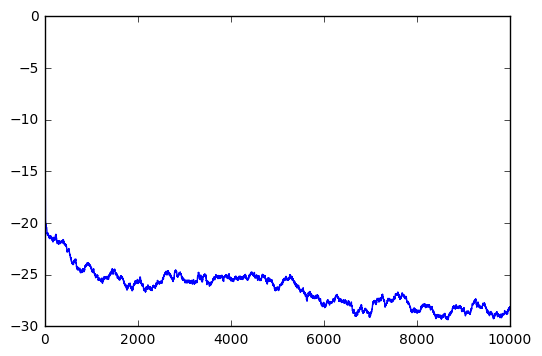

In [18]:
samples_original = np.array(samples_original)
plt.plot(samples_original[:,0])

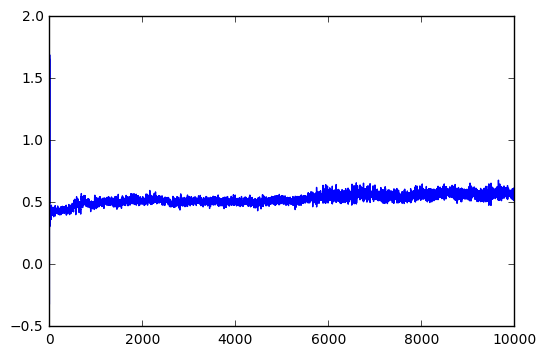

In [19]:
plt.plot(samples_original[:,1])

In [15]:
%%time
samplesSGHMC_c = []
b = np.array([-1., 1])
for i in range(nsample):
    b = sghmc_vectorNew(gradU_c_data_SGHMC, etaSGHMC, L, alpha, b.copy(), V)
    samplesSGHMC_c.append(b)

CPU times: user 3min 51s, sys: 40 ms, total: 3min 51s
Wall time: 3min 51s


In [16]:
def hmc_vector(U, gradU, m, dt, nstep, x, MH):
    p = np.random.randn(len(x)) * np.sqrt(m)
    oldX = x.copy()
    oldEnergy = 0.5 * (1./m) * p.dot(p)  + U(x)
    for i in range(nstep):
        p -= gradU(x) * dt/2.
        x +=  1./m * p * dt
        p -= gradU(x) * dt/2.
    newEnergy = 0.5 * (1./m) * p.dot(p)  + U(x)
    
    if MH and np.random.random() > np.exp(oldEnergy - newEnergy): # Metropolis-Hastings
        x = oldX.copy()
    return x.copy()

In [17]:
minibatch = 1.
gradU_c_data_HMC = functools.partial(gradU_c_data, minibatch)

nsample = 10000
m = 1.
dt = 0.001
nstep = 50
MH=False

In [18]:
%%time
samplesHMC_c = []
b = np.array([-1.,1.])
for i in range(nsample):
    b = hmc_vector( U_c_data, gradU_c_data_HMC, m, dt, nstep, b.copy(), MH )
    samplesHMC_c.append(b)

CPU times: user 8min 34s, sys: 228 ms, total: 8min 34s
Wall time: 8min 34s


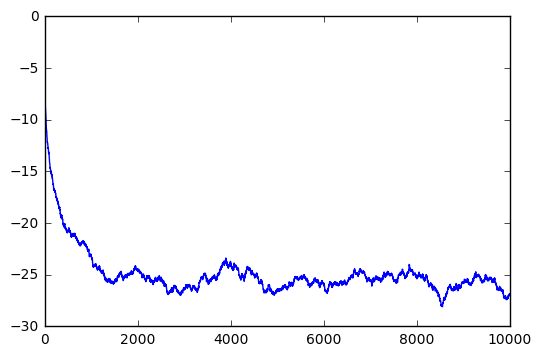

In [15]:
samplesSGHMC_c = np.array(samplesSGHMC_c)
plt.plot(samplesSGHMC_c[:,0])

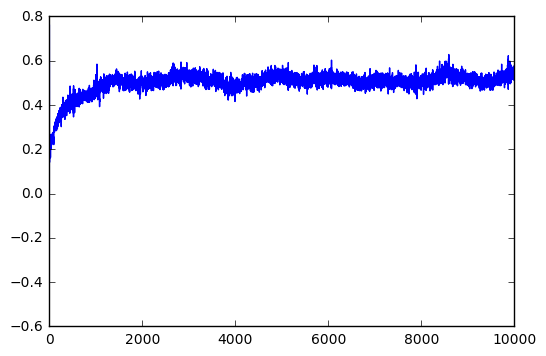

In [16]:
plt.plot(samplesSGHMC_c[:,1])